In [ ]:
!pip install git+https://github.com/awslabs/gluonts.git

In [1]:
%matplotlib inline

import multiprocessing
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from itertools import islice

In [36]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.torch.distributions import NegativeBinomialOutput

In [3]:
from model.patch_hom import PatchHoMEstimator

In [52]:
dataset = get_dataset("taxi_30min")

In [61]:
estimator = PatchHoMEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*7,
    scaling="std",
    patch_len=40,
    num_encoder_layers=3,
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50,),
)

In [62]:
predictor = estimator.train(
    training_data=dataset.train,
    shuffle_buffer_length=1024,
    cache_data=True,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type          | Params
----------------------------------------
0 | model | PatchHoMModel | 771 K 
----------------------------------------
770 K     Trainable params
576       Non-trainable params
771 K     Total params
3.085     Total estimated model params size (MB)


Training: |                                                                                                   …

Epoch 0, global step 100: 'train_loss' reached 2.85408 (best 2.85408), saving model to '/Users/kashif/Github/HoMM/src/lightning_logs/version_11/checkpoints/epoch=0-step=100.ckpt' as top 1


ValueError: Expected parameter total_count (Tensor of shape (128, 24)) of distribution NegativeBinomial(total_count: torch.Size([128, 24]), logits: torch.Size([128, 24])) to satisfy the constraint GreaterThanEq(lower_bound=0), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='mps:0',
       grad_fn=<SqueezeBackward1>)

In [55]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor
)

In [56]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [57]:
evaluator = Evaluator()

In [58]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))


Running evaluation: 67984it [00:00, 108295.81it/s]
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif

# Electricity

In [13]:
agg_metrics

{'MSE': 1538157.4446712136,
 'abs_error': 8157607.954833166,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.7060922690435314,
 'MAPE': 0.10007606697930344,
 'sMAPE': 0.10393042618621838,
 'MSIS': 5.689099546927959,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 3506662.281405609,
 'Coverage[0.1]': 0.07254116599910992,
 'QuantileLoss[0.2]': 5580559.924332984,
 'Coverage[0.2]': 0.17534490431686695,
 'QuantileLoss[0.3]': 6972091.945130443,
 'Coverage[0.3]': 0.28220961281708945,
 'QuantileLoss[0.4]': 7808693.941737063,
 'Coverage[0.4]': 0.38505043762053104,
 'QuantileLoss[0.5]': 8157607.996868507,
 'Coverage[0.5]': 0.48611111111111116,
 'QuantileLoss[0.6]': 8024966.100528655,
 'Coverage[0.6]': 0.5860591900311527,
 'QuantileLoss[0.7]': 7356129.29597811,
 'Coverage[0.7]': 0.6849503041091826,
 'QuantileLoss[0.8]': 6170945.488231034,
 'Coverage[0.8]': 0.7843977154724817,
 'QuantileLoss[0.9]': 4207499.909695979,


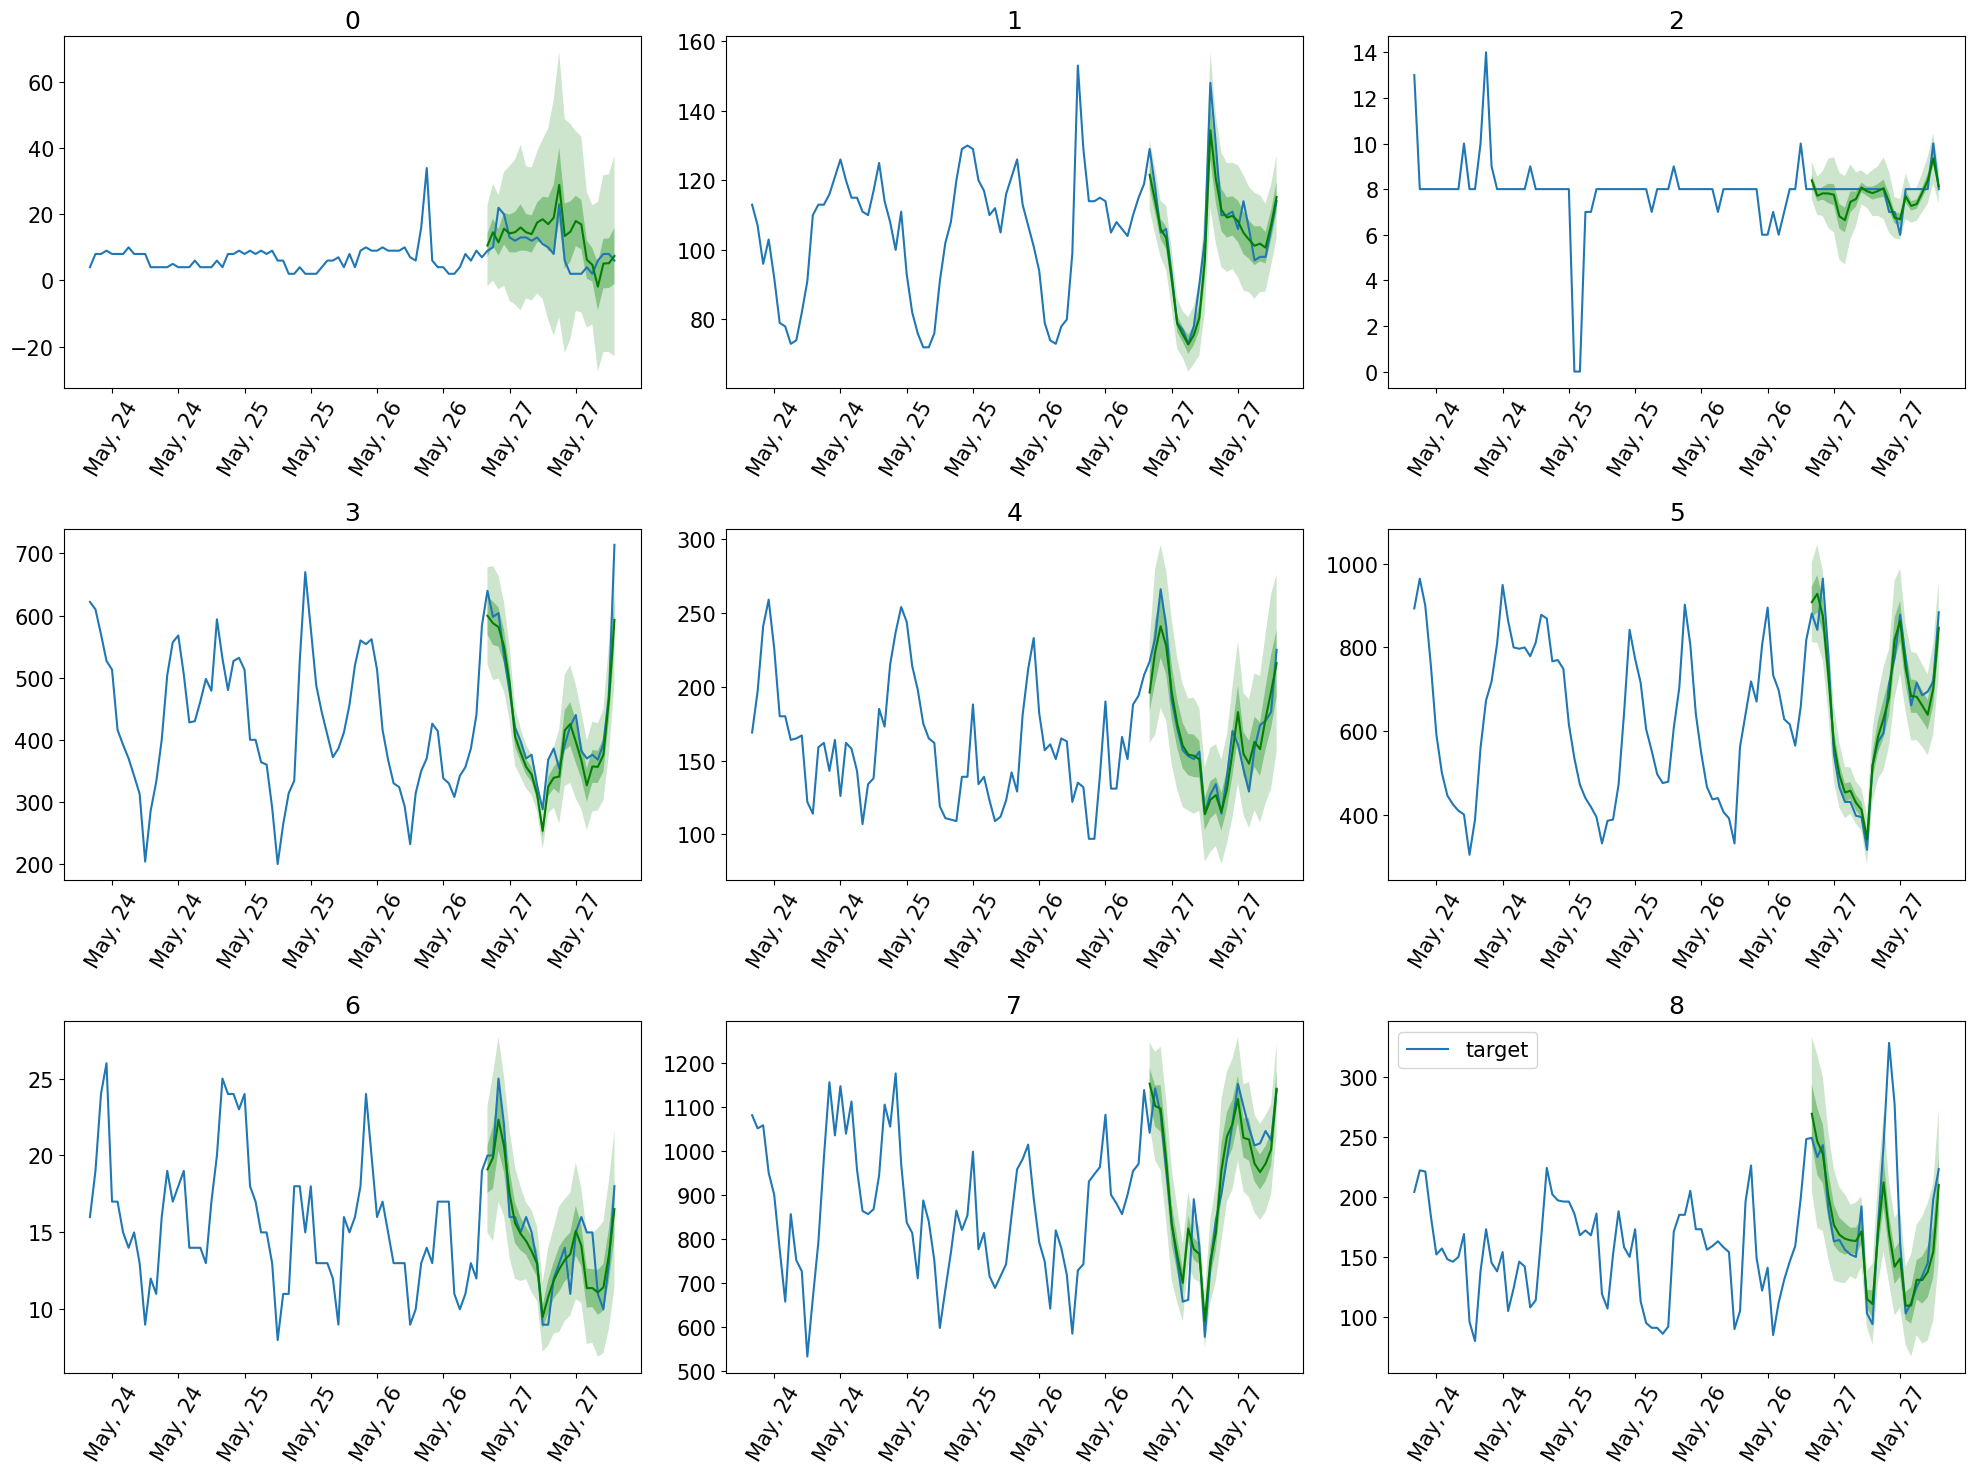

In [14]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length:].to_timestamp()
    
    plt.plot(ts, label="target")
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

# Exchange

In [12]:
agg_metrics

{'MSE': 0.00014531893503729522,
 'abs_error': 9.716640482656658,
 'abs_target_sum': 975.9766580164433,
 'abs_target_mean': 0.8133138816803693,
 'seasonal_error': 0.006515919403041842,
 'MASE': 1.5927339831633567,
 'MAPE': 0.011373469447717069,
 'sMAPE': 0.011279394576946895,
 'MSIS': 10.979031998511166,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 3.996894402056933,
 'Coverage[0.1]': 0.19083333333333335,
 'QuantileLoss[0.2]': 6.619984305277467,
 'Coverage[0.2]': 0.3325,
 'QuantileLoss[0.3]': 8.28894674386829,
 'Coverage[0.3]': 0.4408333333333333,
 'QuantileLoss[0.4]': 9.362761655449868,
 'Coverage[0.4]': 0.5383333333333333,
 'QuantileLoss[0.5]': 9.716640482656658,
 'Coverage[0.5]': 0.6375,
 'QuantileLoss[0.6]': 9.291491339355707,
 'Coverage[0.6]': 0.7075,
 'QuantileLoss[0.7]': 8.209891889616848,
 'Coverage[0.7]': 0.7991666666666667,
 'QuantileLoss[0.8]': 6.614425084367394,
 'Coverage[0.8]': 0.8625,
 'QuantileLoss[0.9]': 4.313059121929109,
 'Coverage[0.9]': 0.9475,
 'RMSE': 0

/var/folders/md/njm1_x2j2dn4cjrx6rmb2v7m0000gn/T/ipykernel_8869/2695427499.py:9: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ts = ts[-4 * dataset.metadata.prediction_length:].to_timestamp()
/Users/kashif/Github/gluon-ts/src/gluonts/model/forecast.py:365: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  self._index = pd.period_range(
/Users/kashif/Github/gluon-ts/src/gluonts/model/forecast.py:365: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  self._index = pd.period_range(
/Users/kashif/Github/gluon-ts/src/gluonts/model/forecast.py:328: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  self.index.to_timestamp(),
/Users/kashif/Github/gluon-ts/src/gluonts/mod

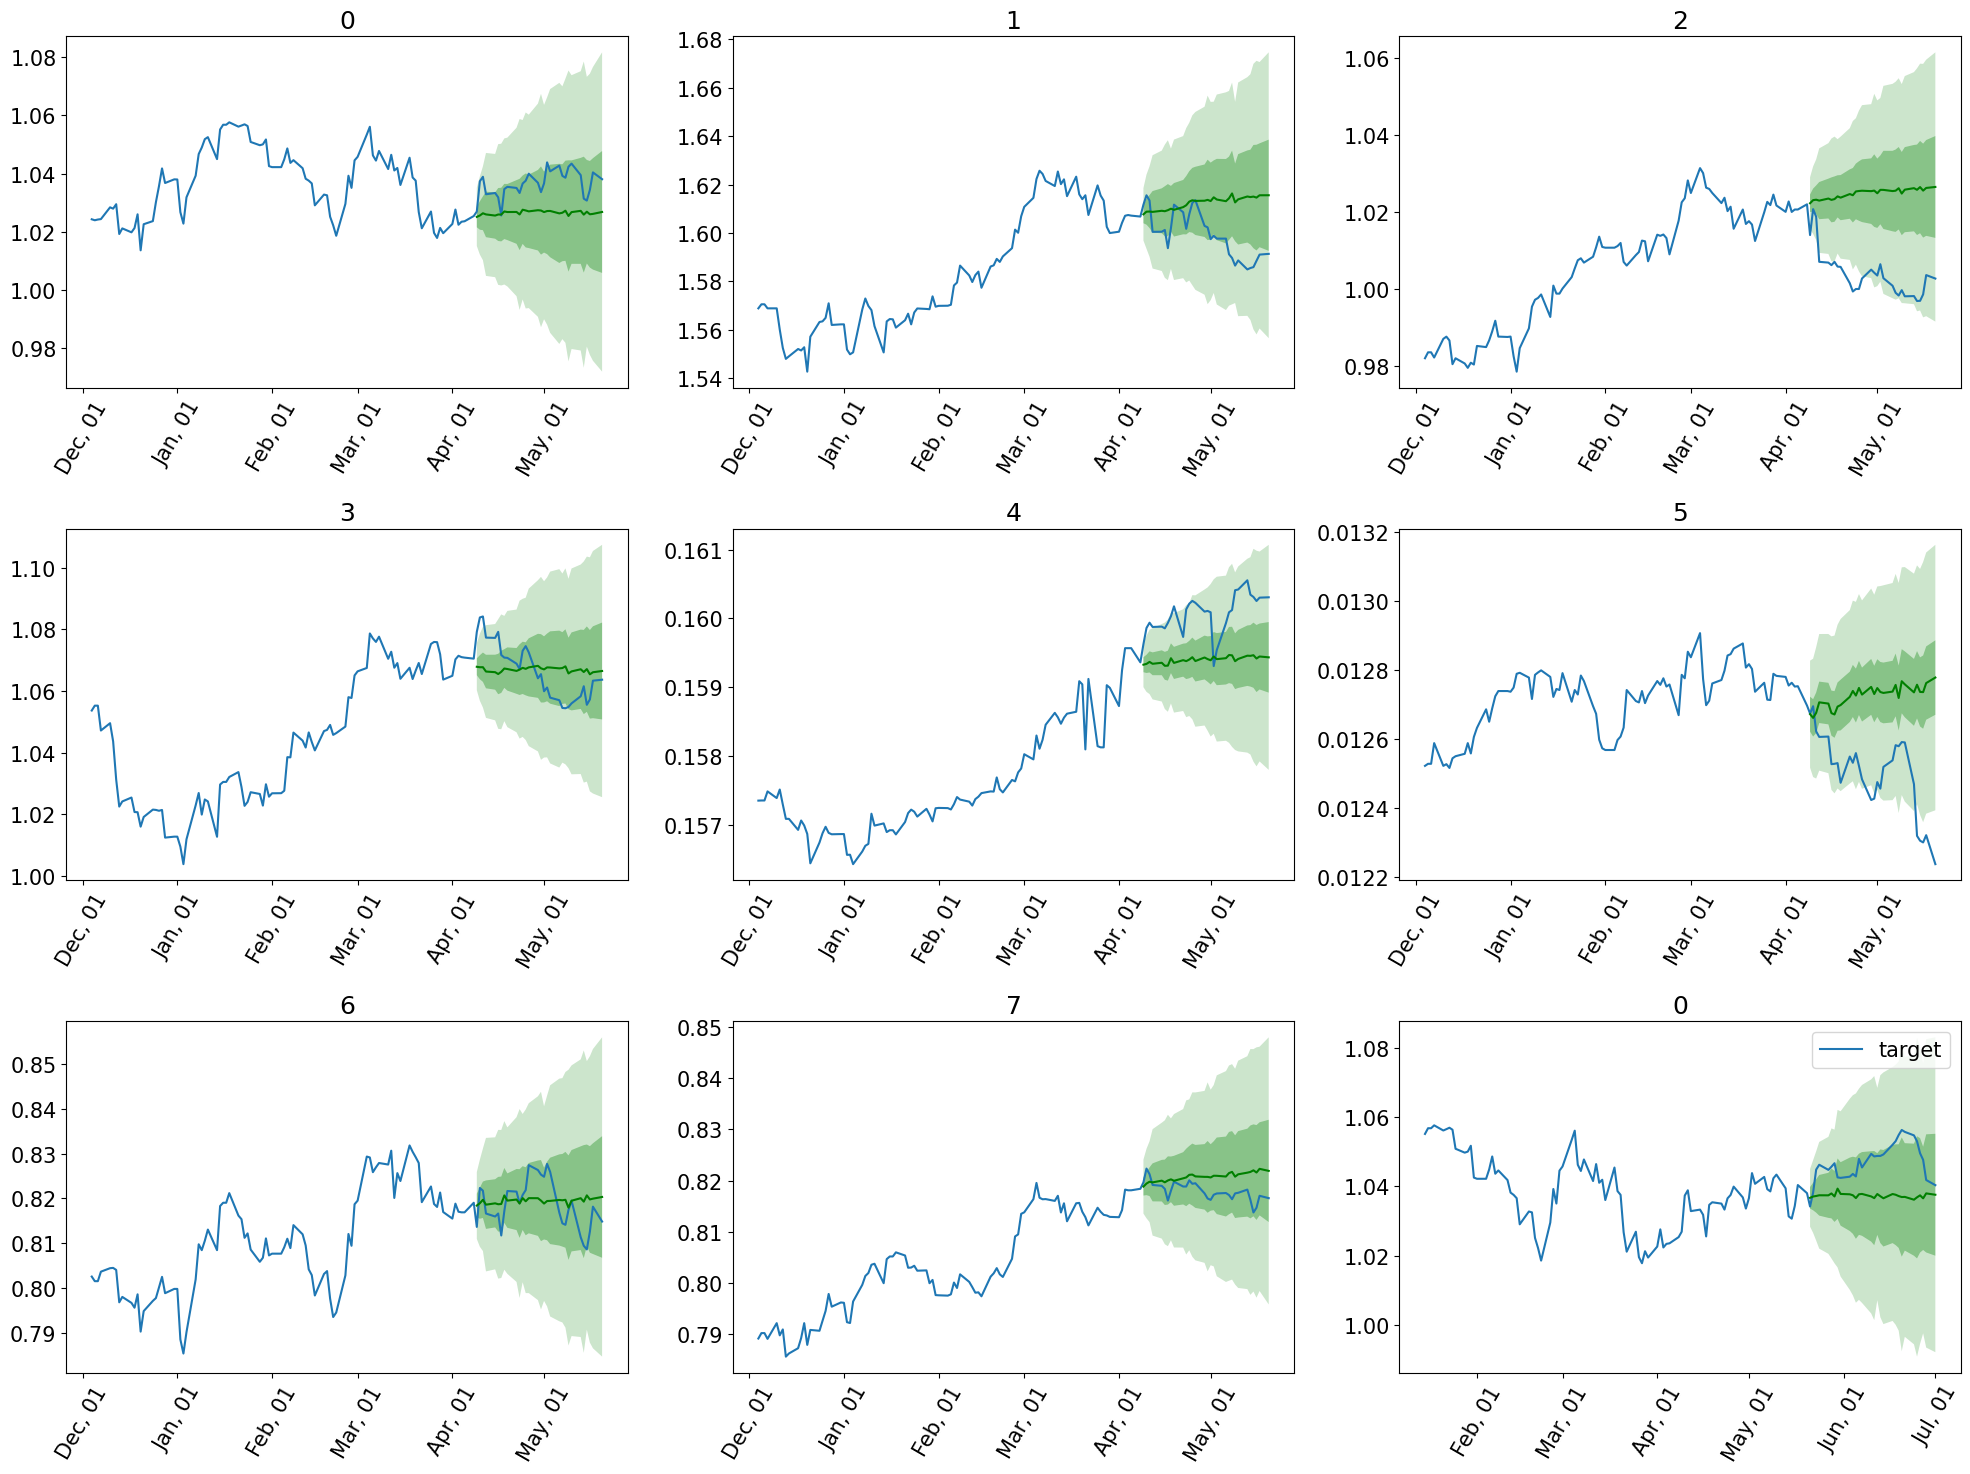

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length:].to_timestamp()
    
    plt.plot(ts, label="target")
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

# Solar

In [23]:
agg_metrics

{'MSE': 1195.0271668087746,
 'abs_error': 412297.9118690491,
 'abs_target_sum': 708873.5020904541,
 'abs_target_mean': 30.799161543728452,
 'seasonal_error': 13.175128459742648,
 'MASE': 1.3635289245016087,
 'MAPE': 3.4339101601286837,
 'sMAPE': 1.407447366445977,
 'MSIS': 6.0521933538504555,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 152275.3042394318,
 'Coverage[0.1]': 0.058394160583941604,
 'QuantileLoss[0.2]': 255907.70114802127,
 'Coverage[0.2]': 0.17040319777546054,
 'QuantileLoss[0.3]': 337630.2080786467,
 'Coverage[0.3]': 0.26464198818213414,
 'QuantileLoss[0.4]': 390105.787074542,
 'Coverage[0.4]': 0.3470629127563434,
 'QuantileLoss[0.5]': 412297.91190320253,
 'Coverage[0.5]': 0.42057698992005565,
 'QuantileLoss[0.6]': 402541.57112131116,
 'Coverage[0.6]': 0.4891814389989573,
 'QuantileLoss[0.7]': 358160.96894035337,
 'Coverage[0.7]': 0.5592196732707683,
 'QuantileLoss[0.8]': 273264.6387980938,
 'Coverage[0.8]': 0.6479405630865485,
 'QuantileLoss[0.9]': 144155.914

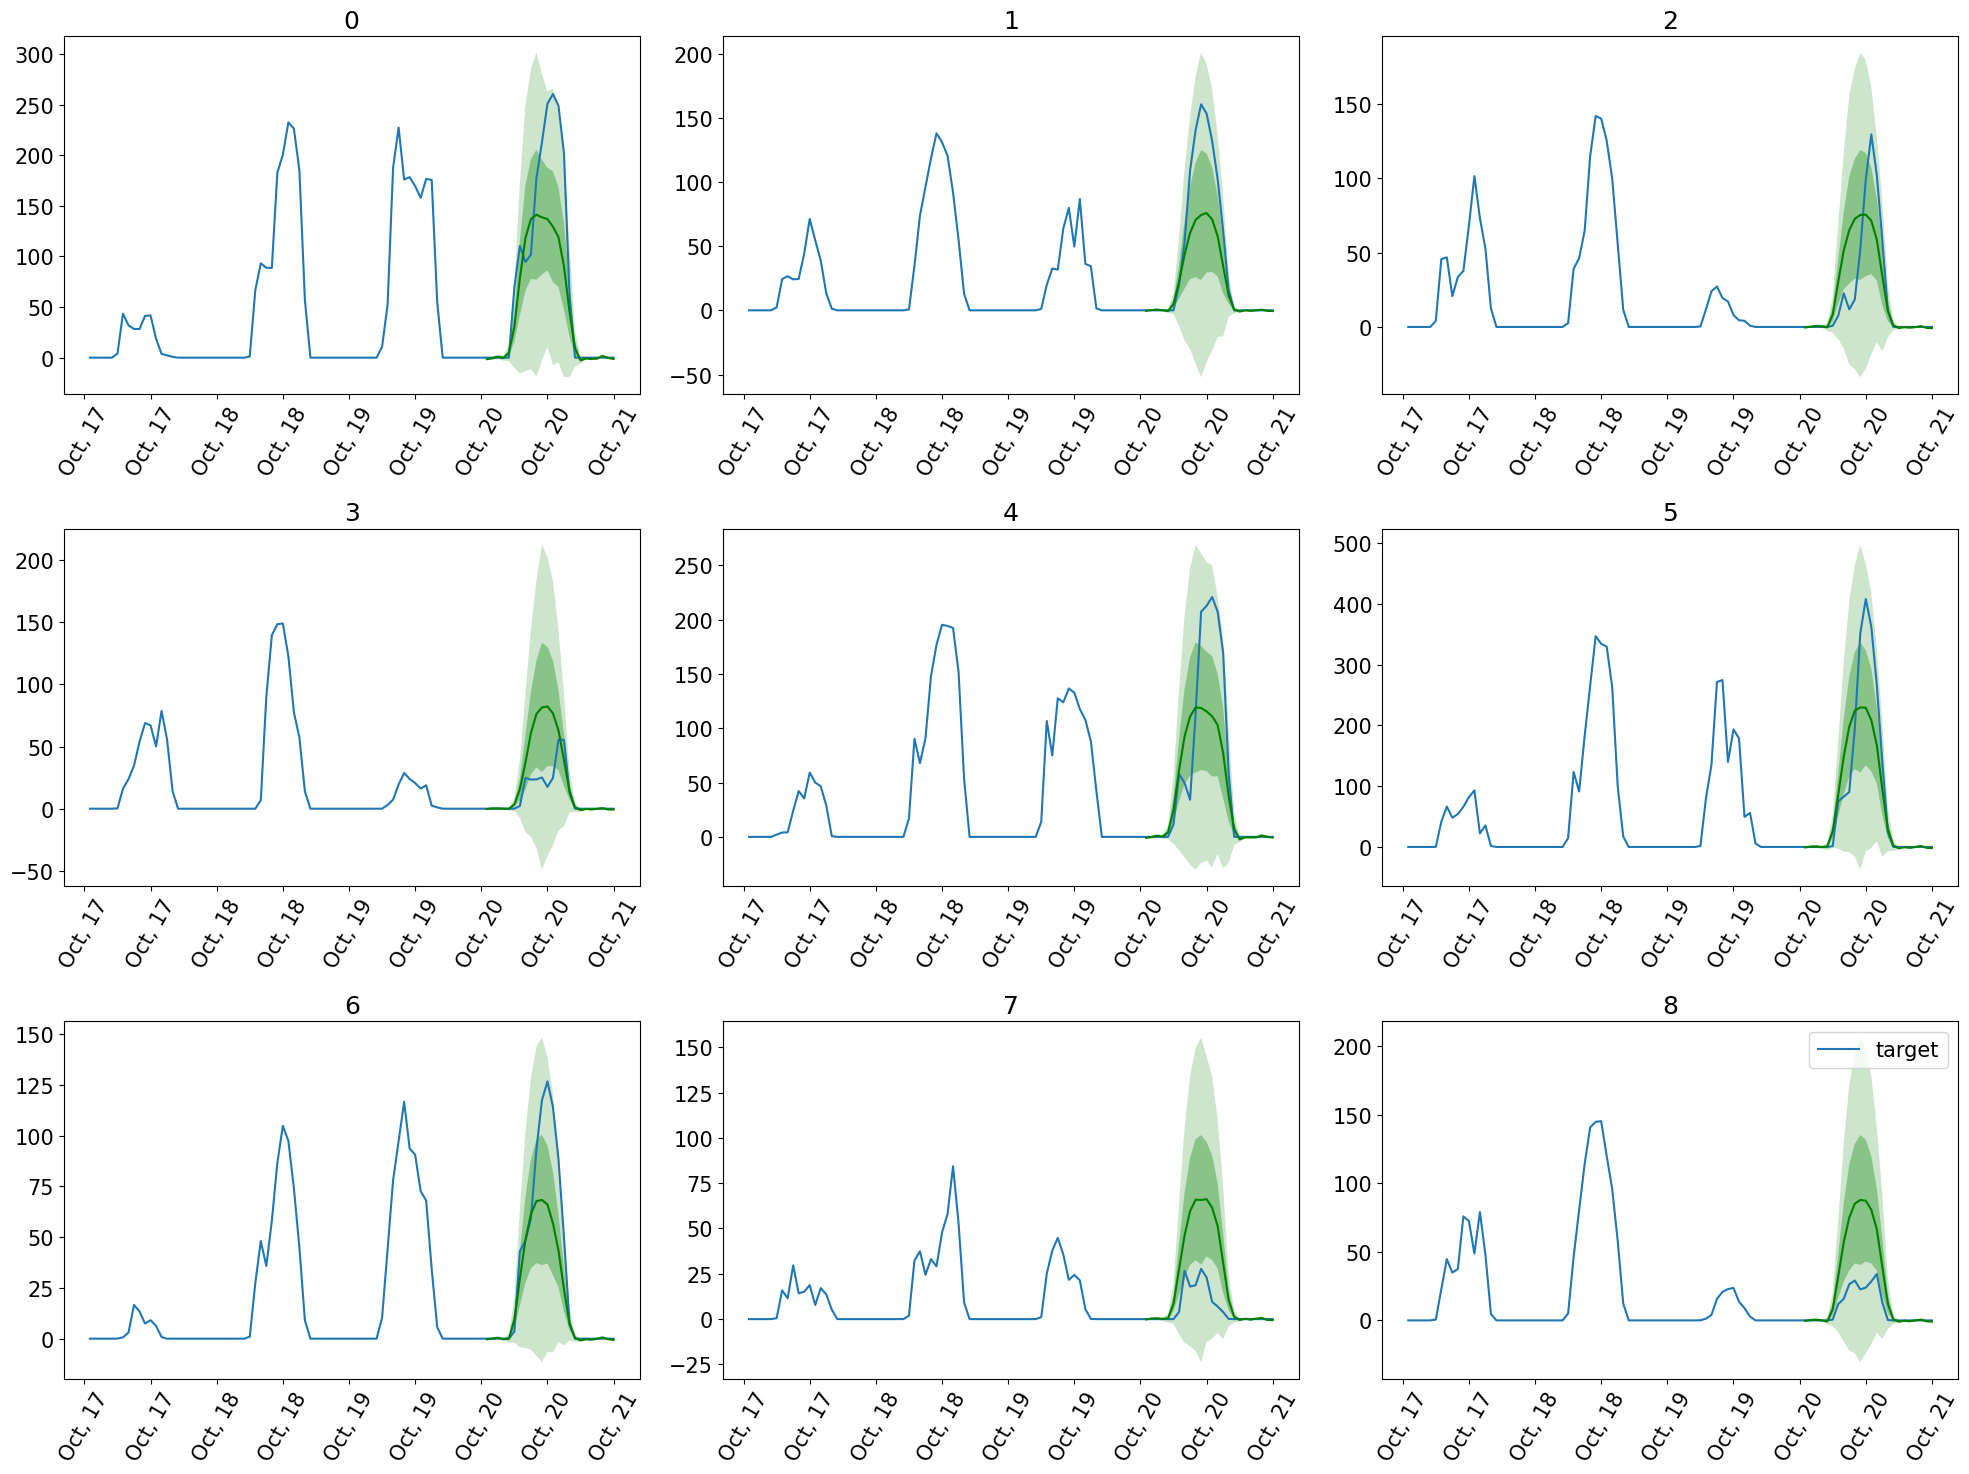

In [24]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length:].to_timestamp()
    
    plt.plot(ts, label="target")
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

# Traffic

In [32]:
agg_metrics

{'MSE': 0.0006492269452895844,
 'abs_error': 1353.1311905891635,
 'abs_target_sum': 8672.5710073933,
 'abs_target_mean': 0.0598868288545002,
 'seasonal_error': 0.015220711169889631,
 'MASE': 0.5906189891736042,
 'MAPE': 0.21333169983485592,
 'sMAPE': 0.15912026400821813,
 'MSIS': 6.786516847247005,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 583.155711106665,
 'Coverage[0.1]': 0.07104877914042647,
 'QuantileLoss[0.2]': 893.9893553057278,
 'Coverage[0.2]': 0.16938736051265055,
 'QuantileLoss[0.3]': 1118.126680867355,
 'Coverage[0.3]': 0.26801596508673076,
 'QuantileLoss[0.4]': 1270.3235555425695,
 'Coverage[0.4]': 0.3618453762015247,
 'QuantileLoss[0.5]': 1353.1311907154013,
 'Coverage[0.5]': 0.4546873273671418,
 'QuantileLoss[0.6]': 1366.934796991959,
 'Coverage[0.6]': 0.5495732515744116,
 'QuantileLoss[0.7]': 1312.397133785687,
 'Coverage[0.7]': 0.6505151364490112,
 'QuantileLoss[0.8]': 1181.8747858209651,
 'Coverage[0.8]': 0.7622914595072369,
 'QuantileLoss[0.9]': 933.157

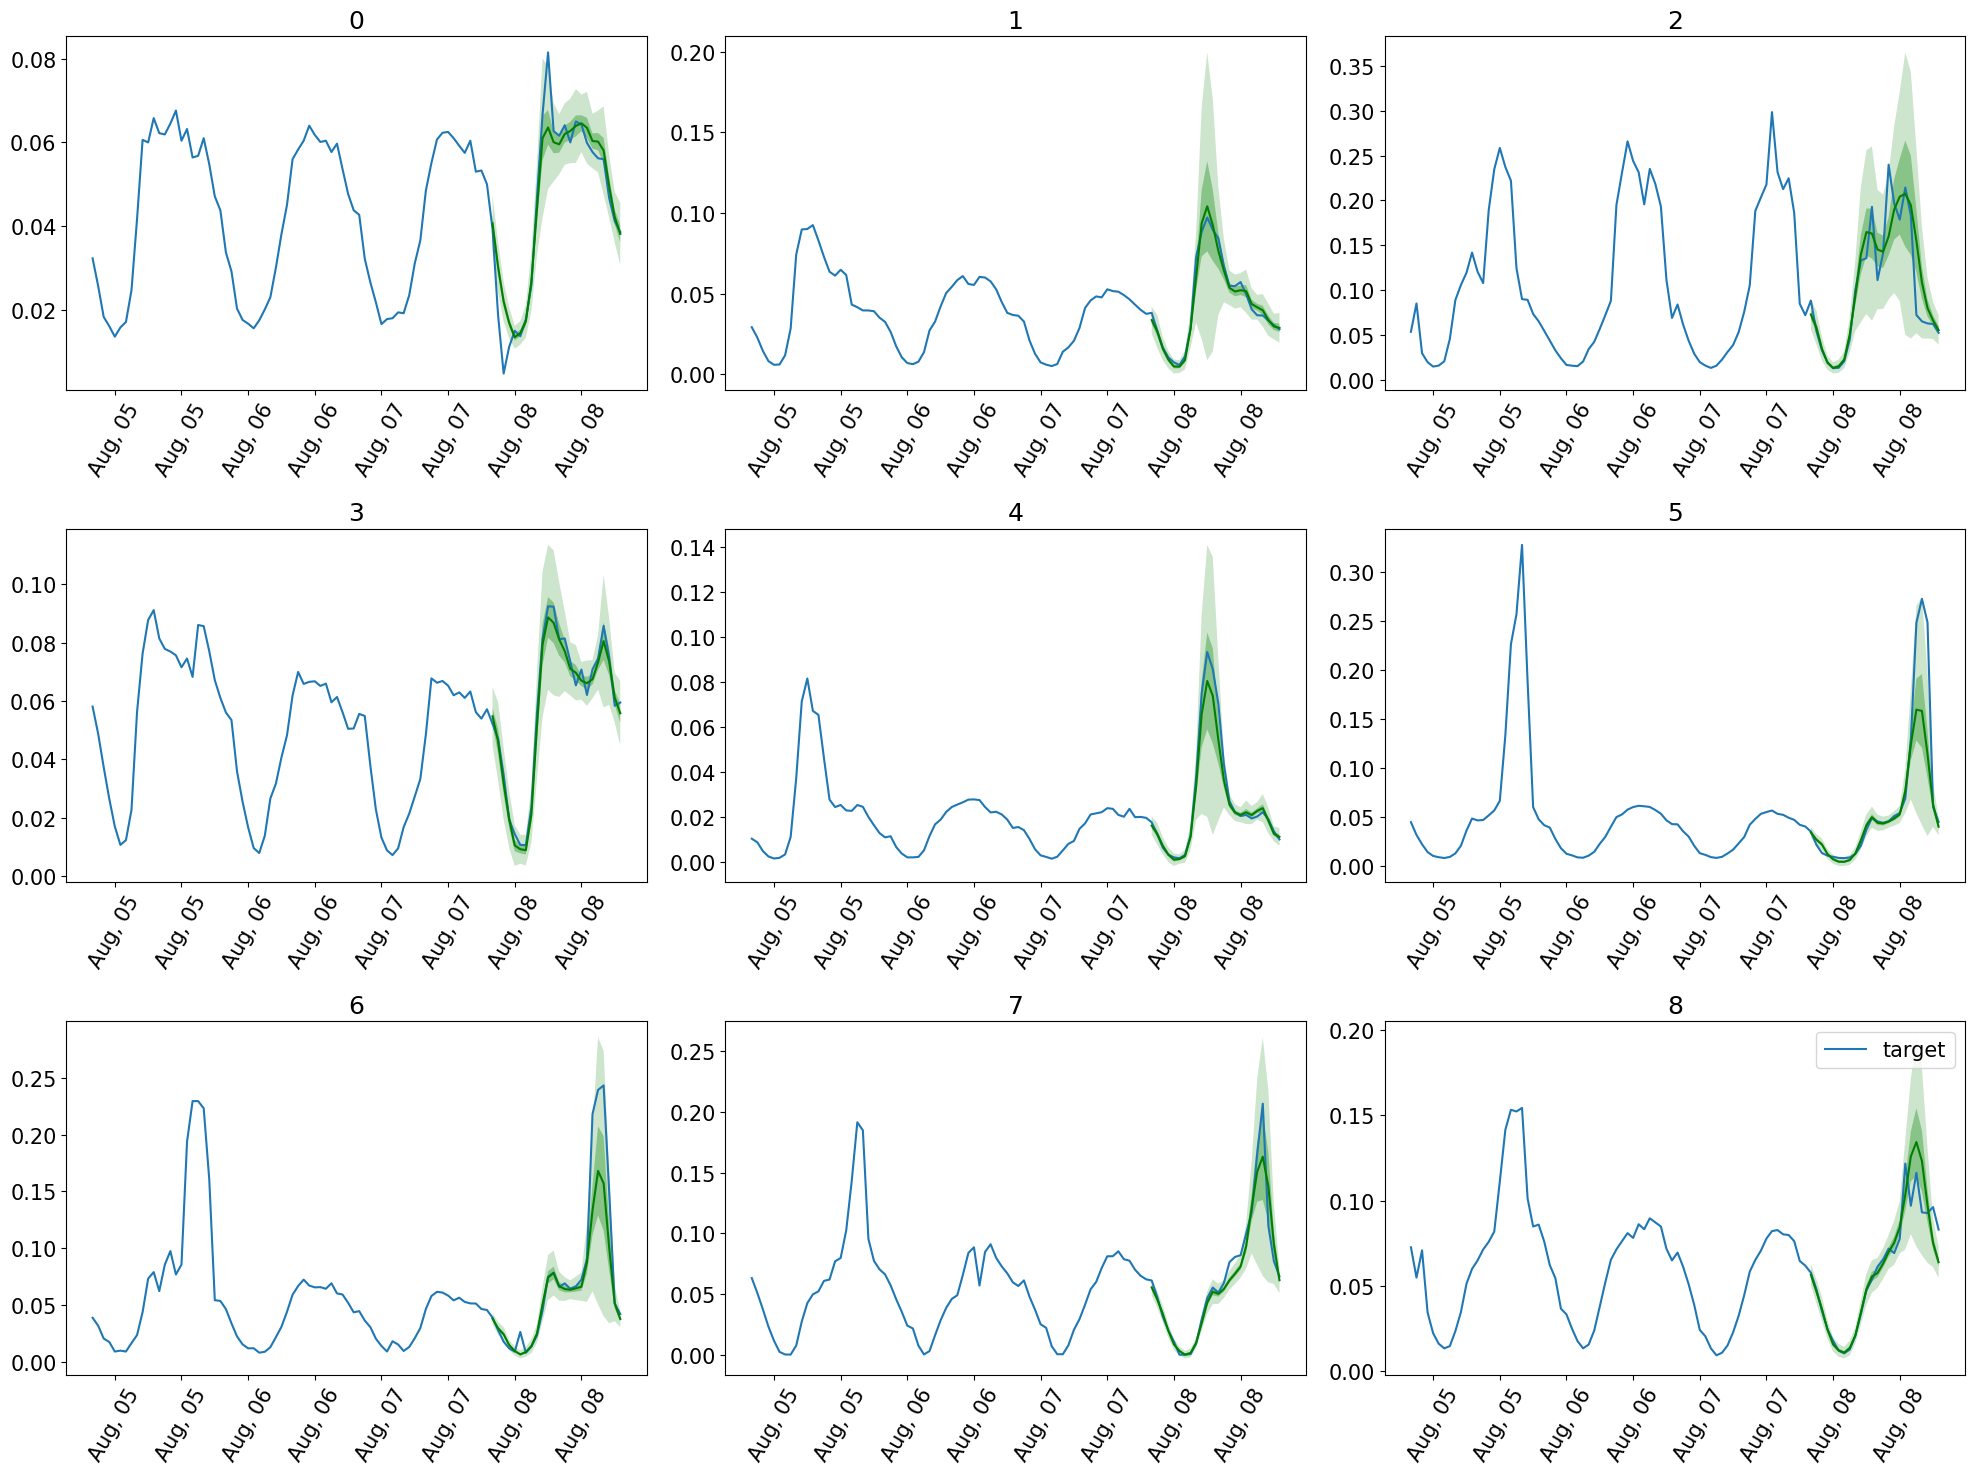

In [33]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length:].to_timestamp()
    
    plt.plot(ts, label="target")
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

# Wikipedia

In [49]:
agg_metrics

{'MSE': 36281600.90637813,
 'abs_error': 991970991.7238617,
 'abs_target_sum': 4139290389.0,
 'abs_target_mean': 2894.1027016255903,
 'seasonal_error': 759.9957754325233,
 'MASE': 1.1191456241436262,
 'MAPE': 0.20757795078849026,
 'sMAPE': 0.18023145434252555,
 'MSIS': 20.364446659119725,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 328944375.04878694,
 'Coverage[0.1]': 0.05033525607411291,
 'QuantileLoss[0.2]': 535504215.6616791,
 'Coverage[0.2]': 0.20014193322845655,
 'QuantileLoss[0.3]': 721584787.4682624,
 'Coverage[0.3]': 0.34119279846180733,
 'QuantileLoss[0.4]': 874967023.8197906,
 'Coverage[0.4]': 0.4550281419332285,
 'QuantileLoss[0.5]': 991970991.5236435,
 'Coverage[0.5]': 0.5488180388044048,
 'QuantileLoss[0.6]': 1070849659.5149323,
 'Coverage[0.6]': 0.6305638874322671,
 'QuantileLoss[0.7]': 1106862721.4450903,
 'Coverage[0.7]': 0.7070826778535221,
 'QuantileLoss[0.8]': 1087745035.8960907,
 'Coverage[0.8]': 0.7828596399230904,
 'QuantileLoss[0.9]': 974410567.23071

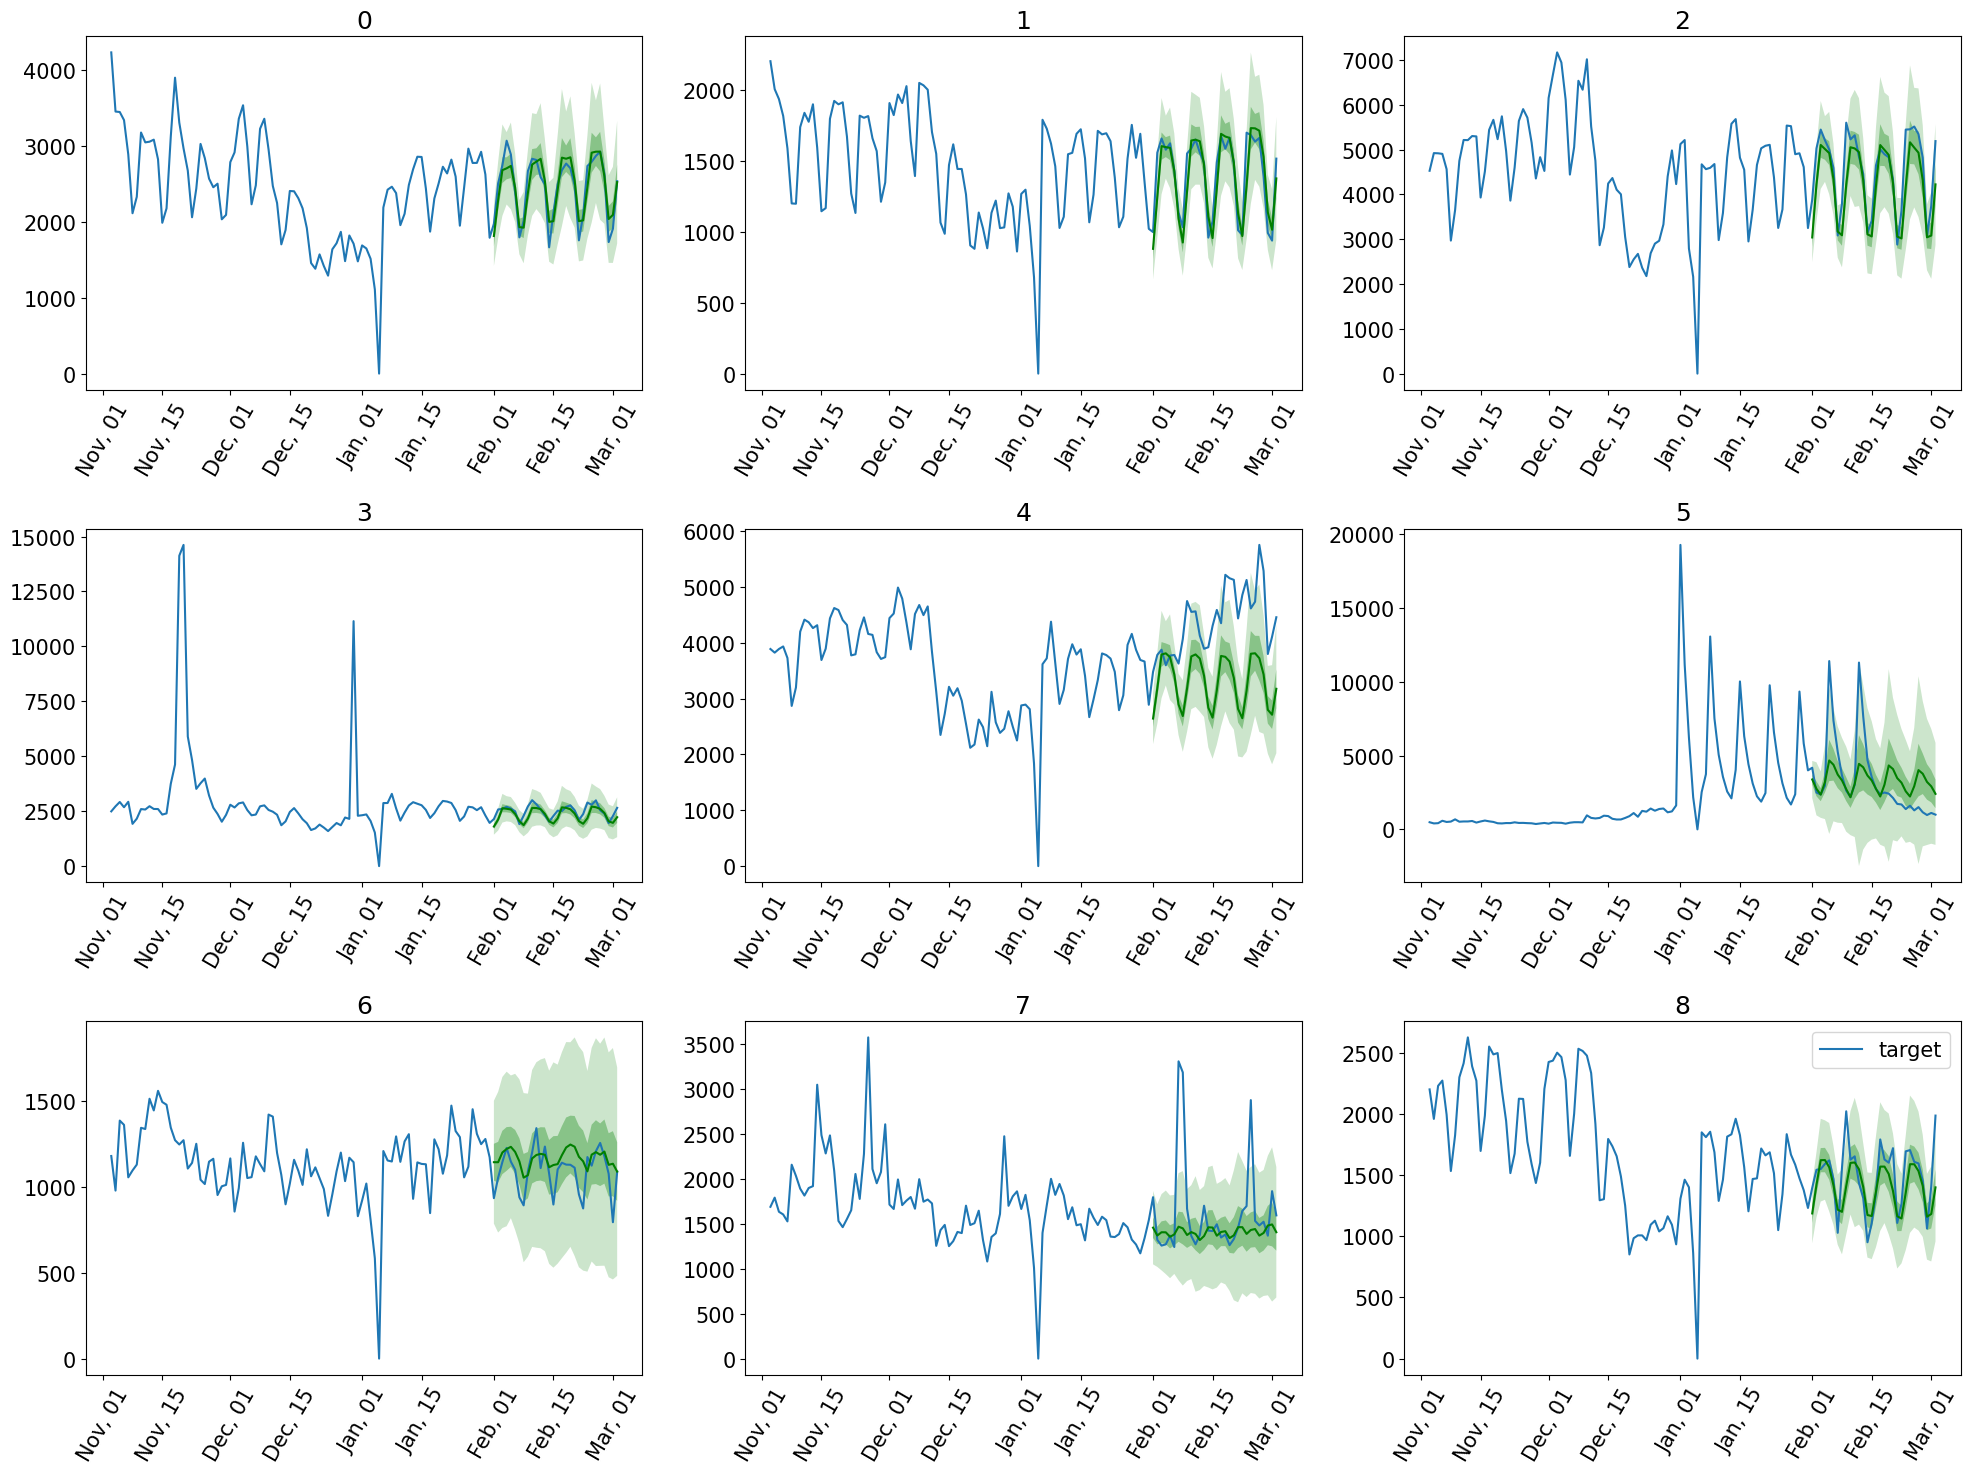

In [50]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length:].to_timestamp()
    
    plt.plot(ts, label="target")
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

# Taxi

In [59]:
agg_metrics

{'MSE': 21.9188604131832,
 'abs_error': 4808959.995802879,
 'abs_target_sum': 12453360.0,
 'abs_target_mean': 7.632531183807954,
 'seasonal_error': 3.785588038176638,
 'MASE': 0.7868757357257635,
 'MAPE': 0.6255764226296152,
 'sMAPE': 0.6218452270098823,
 'MSIS': 5.422631179506353,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 1947298.9508338093,
 'Coverage[0.1]': 0.08384448301561151,
 'QuantileLoss[0.2]': 3156605.7618497848,
 'Coverage[0.2]': 0.21135487761826313,
 'QuantileLoss[0.3]': 4009609.182200694,
 'Coverage[0.3]': 0.33255251235584843,
 'QuantileLoss[0.4]': 4554096.60727613,
 'Coverage[0.4]': 0.4382753049737193,
 'QuantileLoss[0.5]': 4808959.994968712,
 'Coverage[0.5]': 0.5331609888601239,
 'QuantileLoss[0.6]': 4774925.134081793,
 'Coverage[0.6]': 0.6211026368949556,
 'QuantileLoss[0.7]': 4431908.049940551,
 'Coverage[0.7]': 0.7048913469836039,
 'QuantileLoss[0.8]': 3726061.3794728033,
 'Coverage[0.8]': 0.7882620665646818,
 'QuantileLoss[0.9]': 2522168.3760569813,
 'Co

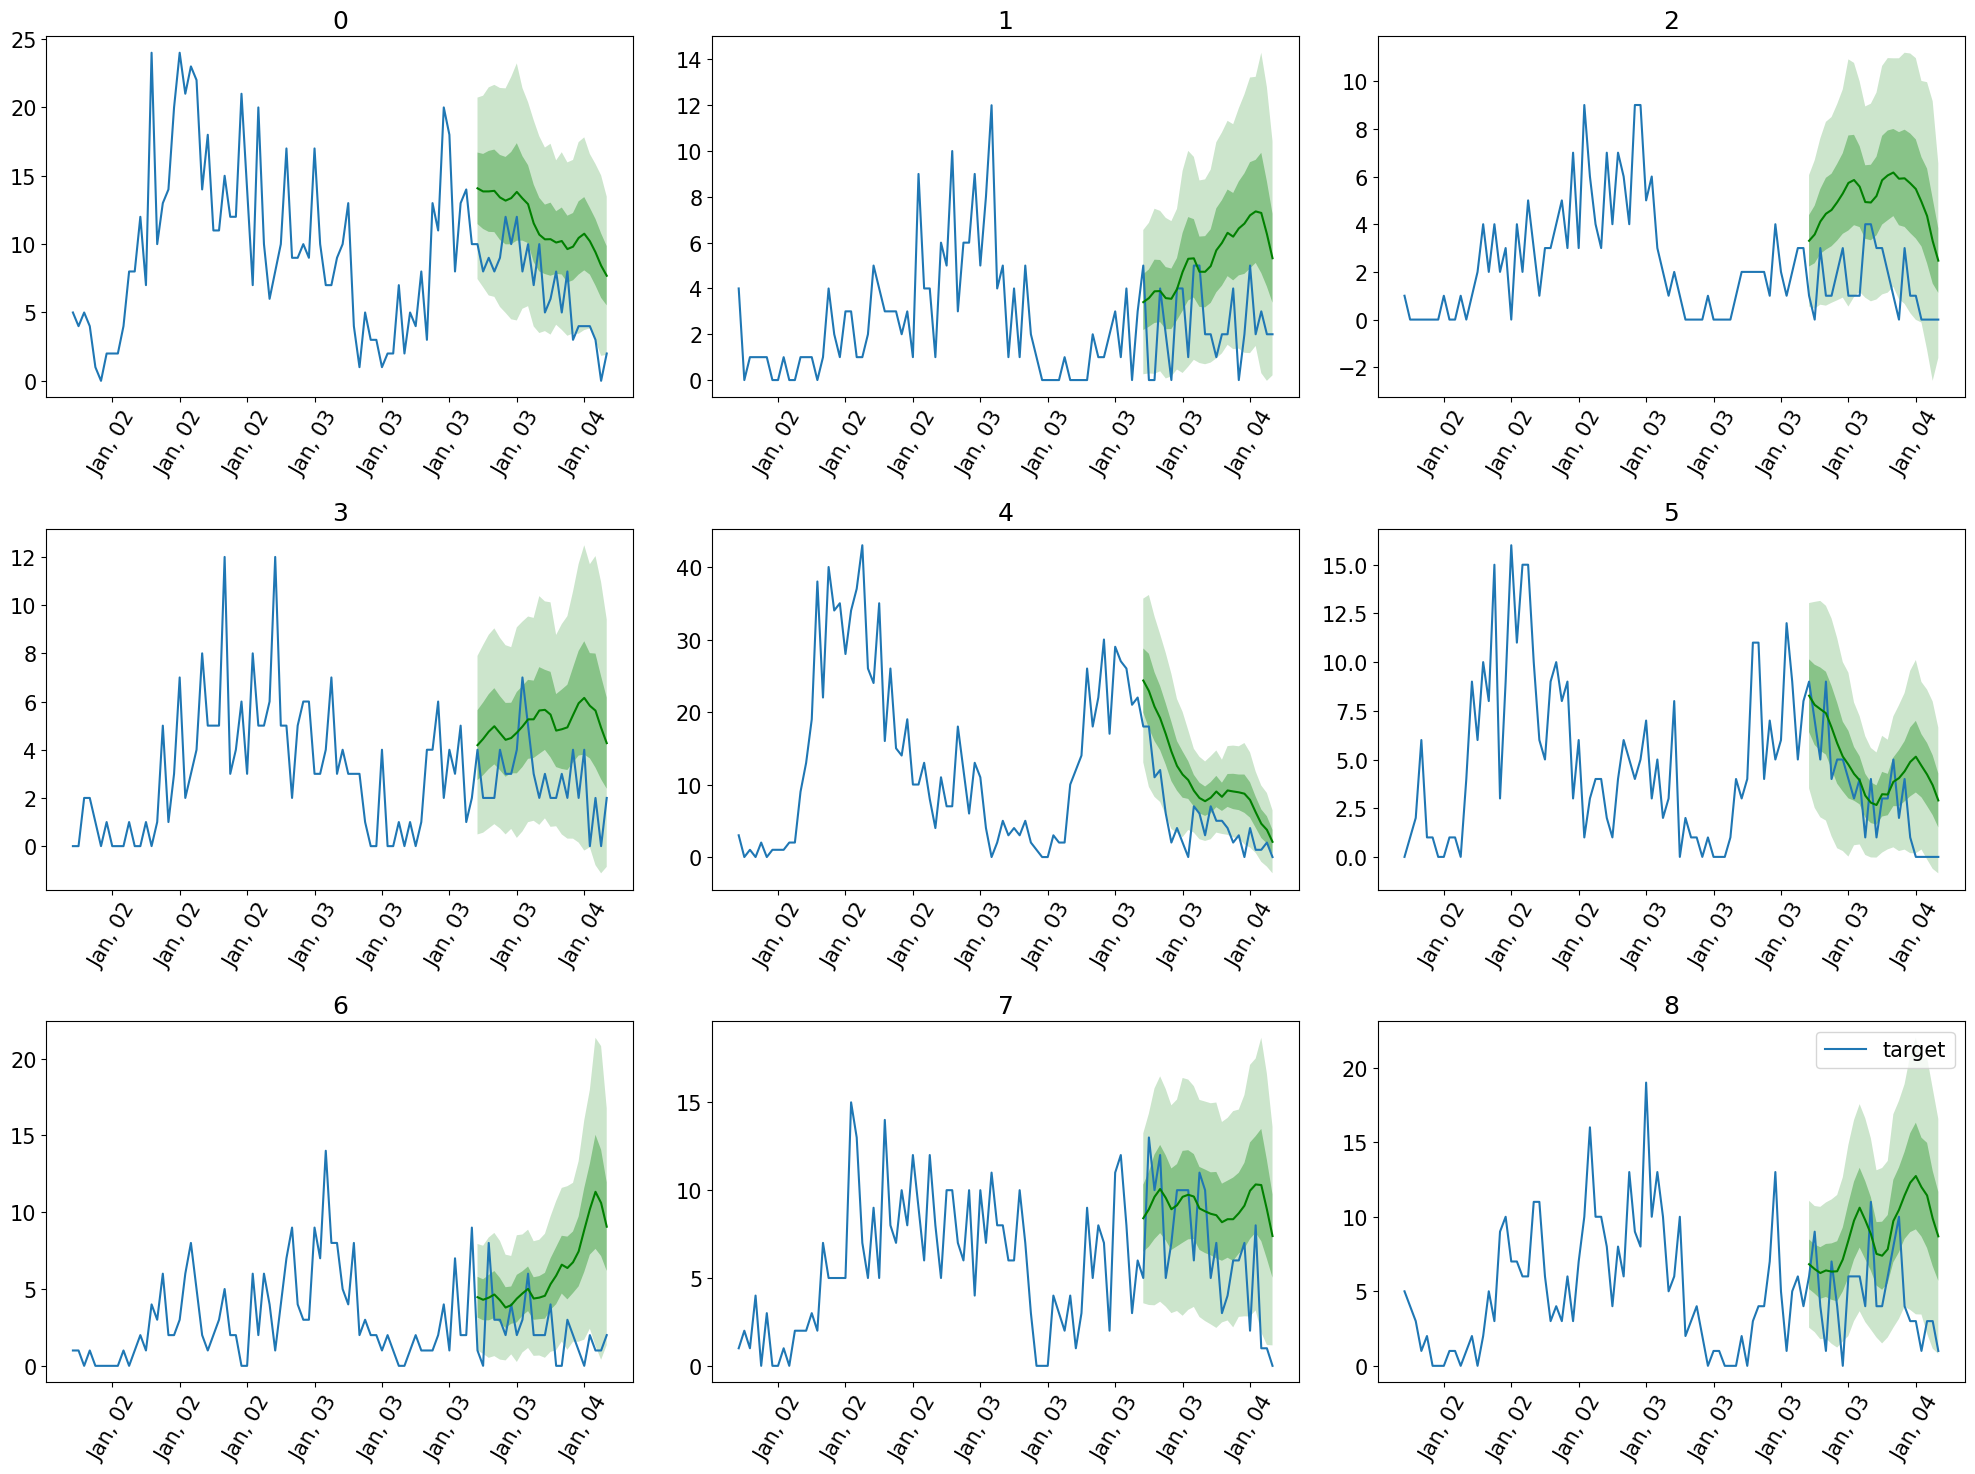

In [60]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length:].to_timestamp()
    
    plt.plot(ts, label="target")
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()